In [6]:
# Install required libraries and setup the notebook
# !pip install pulp

import requests
# url = 'https://raw.githubusercontent.com/NikoStein/CashLog/master/basicModel.py'
# r = requests.get(url, allow_redirects=True)
# open('basicModel.py', 'wb').write(r.content)

# CashLog Basic Analysis

We will use this notebook to implement a basic version of CashLog's decision problem by performing the following steps:
1. Define and load relevent model parameters
2. Define and initialize the decision variables
3. Define and implement the objective function
3. Define and implement the relevant constraints
4. Solve the problem and anlyse the results
5. Perform sensitivity analysis

### Load the required libraries

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import folium
from tqdm import tqdm
from pulp import *

### The decision problem can be modeled in the sense of a MIP

In [8]:
prob = LpProblem('CashLog_BasicAnalysis', LpMinimize)

### Define and load model parameters

$W:$ Set of warehouses<br>
$R:$ Set of customer regions<br>
$S:$ Set of links between warehouses and regions<br>

$f_i:$ Fixed costs of warehouse $i$<br>
$c_{ij}:$ Costs if region $j$ is served by warehouse $i$<br>

In [9]:
warehouses = pd.read_csv('data/warehouses.csv', index_col='warehouseID')
W = warehouses.index.values

regions = pd.read_csv('data/regions.csv', index_col='regionID')
R = regions.index.values

shifts = pd.read_csv('data/shifts.csv', index_col=['warehouseID', 'regionID'])
S = shifts.index.values

### Define and initialize the decision variables

$x_{ij}:$ Binary variable indicating if region $j$ is served by warehouse $i$<br> 
$y_{i}:$ Binary variable indicating if warehouse $i$ is opened<br>

In [10]:
x = LpVariable.dicts(name='x', indices=S, cat=LpBinary)
y = LpVariable.dicts(name='y', indices=W, cat=LpBinary)

### Define and implement the objective function

We want to minimize the total network costs (variable costs + fixed costs):

$$\min \sum_{i\in W}\sum_{j\in R} x_{ij} c_{ij} + \sum_{i\in W} f_i y_i$$

In [11]:
variableCosts = lpSum([x[i,j] * shifts.loc[i,j].transportationCosts for i,j in S]) 
fixedCosts = lpSum([y[i] * warehouses.loc[i].fixedCosts for i in W])

prob += fixedCosts + variableCosts

### Define and implement the relevant constraints

Regions can only be served by open warehouses:<br>
$$x_{ij} \leq y_{i} \quad \forall i\in W, j\in R$$

Each region has to be served by exactly one warehouse:<br>
$$\sum_{i\in W} x_{ij} = 1 \quad \forall j\in R$$

In [12]:
for i in W:
    for j in R:
        prob += x[i,j] <= y[i]

for j in R:
    prob += lpSum([x[i,j] for i in W]) == 1

### Solve the problem and analyze the results

In [13]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vscode/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/52385d085cc5412f8c3961d4b1fb9f97-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/52385d085cc5412f8c3961d4b1fb9f97-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22150 COLUMNS
At line 152057 RHS
At line 174203 BOUNDS
At line 195876 ENDATA
Problem MODEL has 22145 rows, 21672 columns and 64890 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.86319e+07 - 3.31 seconds
Cgl0004I processed model has 22145 rows, 21672 columns (21672 integer (21672 of which binary)) and 64890 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.86319e+07
Cbc0038I Before mini branch and bound, 21672 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound di

1

In [14]:
fixedCosts = sum([y[i].varValue * warehouses.loc[i].fixedCosts for i in W])
variableCosts = sum([x[i,j].varValue * shifts.loc[i,j].transportationCosts for i,j in S])
print('Minimal costs are {:0,.0f} Euro'.format(prob.objective.value()))
print('Variable Costs: {:0,.0f}€\nFixed costs: {:0,.0f}€'.format(variableCosts,
                                                                 fixedCosts))
print('To minimize costs the following warehouses should be closed:')
for i in W:
    if y[i].varValue <= 0.1:
        print('   -{}'.format(warehouses.loc[i].city))

Minimal costs are 98,631,921 Euro
Variable Costs: 66,267,921€
Fixed costs: 32,364,000€
To minimize costs the following warehouses should be closed:
   -Albacete
   -Barcelona
   -Ciudad real
   -La coruña
   -Granada
   -San sebastian
   -Lerida
   -La rioja
   -Madrid
   -Navarra
   -Oviedo
   -Palencia
   -Pontevedra
   -Salamanca
   -Santander
   -Segovia
   -Sevilla
   -Soria
   -Toledo
   -Valencia
   -Valladolid
   -Bilbao
   -Zamora
   -Zaragoza


### Perform sensitivity analysis

To perform sensitivity analysis and get a deeper understanding of the optimal decisions we solve multiple instances of the problem. In order to have a clean notebook we outsourced the model and import it for the analysis.

We can instantiate an instance of the model via the ```CashLogWLP``` class and specify the costs per shift.

In [15]:
from basicModel import CashLogWLP

In [16]:
wlp = CashLogWLP()
wlp.solve(n_warehouses=-1)
print('Minimal costs are {:0,.0f} Euro'.format(wlp.totalCosts))
print('Variable Costs: {:0,.0f}€\nFixed costs: {:0,.0f}€'.format(wlp.variableCosts,
                                                                 wlp.fixedCosts))

Minimal costs are 98,631,921 Euro
Variable Costs: 66,267,921€
Fixed costs: 32,364,000€


We can visualize the results of our optimization on a map:

In [17]:
plot_df_regions = pd.DataFrame(wlp.region_results)
plot_df_warehouses = pd.DataFrame(wlp.warehouse_results)
plot_df_warehouses = plot_df_warehouses[plot_df_warehouses.open == 1]
palette = sns.color_palette(None, len(wlp.W)).as_hex()
palette = {wlp.W[i]: palette[i] for i in range(len(wlp.W))}

m = folium.Map(location=[41, -4], zoom_start=6)
plot_df_regions.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                radius=4000, fill=False, popup=row['city'],
                                                color=palette[row['warehouseID']]).add_to(m), axis=1)
plot_df_warehouses.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                   radius=10000, fill=True, popup=row['city'],
                                                   color=palette[row['warehouseID']], 
                                                   fill_opacity=1).add_to(m), axis=1)
m

Additionally, we implemented new constraints in order to force the model to open a given number of warehouses or to open specific warehouese. E.g., we can solve a version of the model where the main facilities in Barcelona and Madrid are required to remain open.

In [ ]:
# Run this cell to find warehouse IDs (Barcelona:8, Madrid: 28)
# wlp.warehouses['city']

In [18]:
wlp = CashLogWLP()
wlp.solve(n_warehouses=-1, force_open=[8, 28])
print('Minimal costs are {:0,.0f} Euro'.format(wlp.totalCosts))
print('Variable Costs: {:0,.0f}€\nFixed costs: {:0,.0f}€'.format(wlp.variableCosts,
                                                                 wlp.fixedCosts))

Minimal costs are 142,656,096 Euro
Variable Costs: 62,064,096€
Fixed costs: 80,592,000€


In [19]:
plot_df_regions = pd.DataFrame(wlp.region_results)
plot_df_warehouses = pd.DataFrame(wlp.warehouse_results)
plot_df_warehouses = plot_df_warehouses[plot_df_warehouses.open == 1]
palette = sns.color_palette(None, len(wlp.W)).as_hex()
palette = {wlp.W[i]: palette[i] for i in range(len(wlp.W))}

m = folium.Map(location=[41, -4], zoom_start=6)
plot_df_regions.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                radius=4000, fill=False, popup=row['city'],
                                                color=palette[row['warehouseID']]).add_to(m), axis=1)
plot_df_warehouses.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                   radius=10000, fill=True, popup=row['city'],
                                                   color=palette[row['warehouseID']], 
                                                   fill_opacity=1).add_to(m), axis=1)
m

We can use the new implementation to solve various versions of the problem and get a deeper understanding of the trade-off between fixed and variable costs:

100%|██████████| 31/31 [02:29<00:00,  4.82s/it]


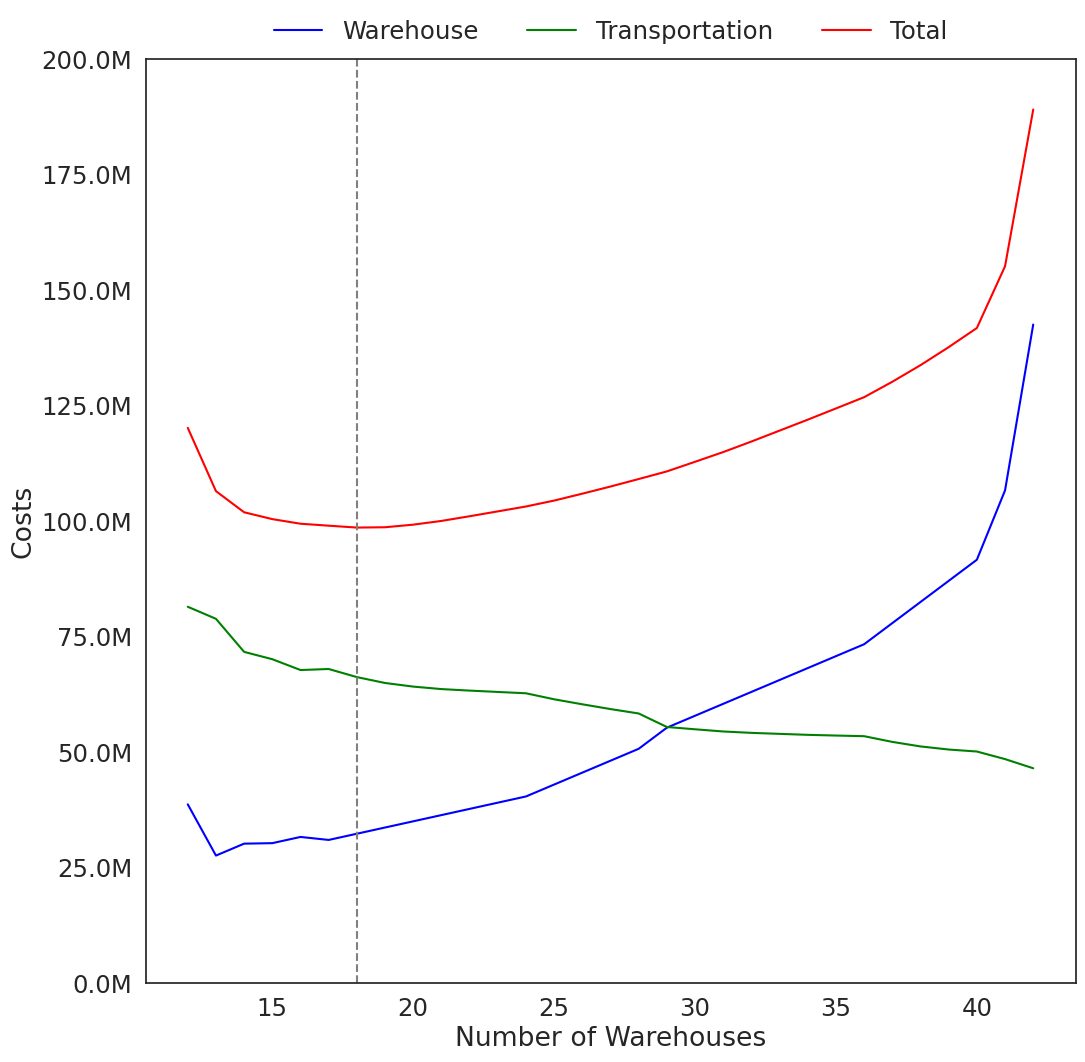

In [20]:
cFixed = {}
cVariable = {}
cTotal = {}
warehouse_results = {}
region_results = {}

wlp = CashLogWLP()

for n in tqdm(range(12, len(wlp.W)+1, 1)):
    wlp.solve(n_warehouses=n)
    cFixed[n] = wlp.fixedCosts
    cVariable[n] = wlp.variableCosts
    cTotal[n] = wlp.totalCosts
    warehouse_results[n] = wlp.warehouse_results
    region_results[n] = wlp.region_results

results_df = pd.DataFrame({'fixed':cFixed, 'transportation':cVariable, 'total':cTotal})
min_costs_n = results_df.total.idxmin()
results_df.reset_index(inplace=True)
plot_df = pd.melt(results_df, id_vars='index', value_vars=['fixed', 'transportation', 'total'])



def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)
plot_df.replace(['fixed', 'transportation', 'total'], ['Warehouse', 'Transportation', 'Total'], inplace=True)
sns.set(font_scale=1.6)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(12, 12))
g = sns.lineplot(data=plot_df, x='index', y='value', hue='variable', palette={'Warehouse': 'blue', 
                                                                              'Transportation': 'green', 
                                                                              'Total': 'red'})
g.axvline(min_costs_n, c='grey', linestyle='--')
ax.set_ylim(0,200000000)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Number of Warehouses')
ax.set_ylabel("Costs")
ax.legend(bbox_to_anchor=[0.5,1.03], loc='center', ncol=3, frameon=False)

Again, we can visualize the results on a map and compare the different region-warehouse allocations depending on the number of open warehouses:

In [ ]:
def map_results(n_warehouses):
    plot_df_regions = pd.DataFrame(region_results[n_warehouses])
    plot_df_warehouses = pd.DataFrame(warehouse_results[n_warehouses])
    plot_df_warehouses = plot_df_warehouses[plot_df_warehouses.open == 1]
    palette = sns.color_palette(None, len(wlp.W)).as_hex()
    palette = {wlp.W[i]: palette[i] for i in range(len(wlp.W))}

    m = folium.Map(location=[41, -4], zoom_start=6)
    plot_df_regions.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                    radius=4000, fill=False, popup=row['city'],
                                                    color=palette[row['warehouseID']]).add_to(m), axis=1)
    plot_df_warehouses.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                       radius=10000, fill=True, popup=row['city'],
                                                       color=palette[row['warehouseID']], 
                                                       fill_opacity=1).add_to(m), axis=1)
    return m

In [ ]:
map_results(n_warehouses=42)